### Sentiment Analysis of movie reviews in NLP

Using the dataset IMDB 50K Movie Reviews (TEST your BERT) from https://www.kaggle.com/datasets/atulanandjha/imdb-50k-movie-reviews-test-your-bert

Columns:

text : Reviews from people.

Sentiment : Negative or Positive tag on the review/feedback (Boolean).

The dataset we use is 50,000 IMDB reviews (25K for train and 25K for test) from the PyTorch-NLP library.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import nltk 
import re
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.utils import plot_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## Dataset Preparation

In [3]:
train_data = pd.read_csv('/Users/millenasiqueiraguimaraes/Downloads/archive-2/train.csv')
test_data = pd.read_csv('/Users/millenasiqueiraguimaraes/Downloads/archive-2/test.csv')

In [4]:
train_data.head()

,text,sentiment
0,"Now, I won't deny that when I purchased this o...",neg
1,"The saddest thing about this ""tribute"" is that...",neg
2,Last night I decided to watch the prequel or s...,neg
3,I have to admit that i liked the first half of...,neg
4,I was not impressed about this film especially...,neg


In [5]:
test_data.head()

,text,sentiment
0,"My daughter liked it but I was aghast, that a ...",neg
1,I... No words. No words can describe this. I w...,neg
2,this film is basically a poor take on the old ...,neg
3,"This is a terrible movie, and I'm not even sur...",neg
4,First of all this movie is a piece of reality ...,pos


In [6]:
train_data['sentiment'].value_counts()

sentiment
neg    12500
pos    12500
Name: count, dtype: int64

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       25000 non-null  object
 1   sentiment  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


Cleaning characters 

In [9]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = text.split()
    text = [word for word in text if word not in nltk.corpus.stopwords.words('english')]  # Remove stop words
    text = ' '.join(text)
    return text

train_data['clean_text'] = train_data['text'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)


Apply Label encoder to make numerical (Positive 1 and Negative 0)

In [10]:
le = LabelEncoder()
train_data['sentiment_enc'] = le.fit_transform(train_data['sentiment'])

In [13]:
X = train_data['text']
y = to_categorical(train_data['sentiment_enc'])

In [14]:
print(X.shape, y.shape)

(25000,) (25000, 2)


## Training process

In [15]:
def plot_model_learning(history, title):
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    df = pd.DataFrame(history.history)
    df[['accuracy', 'val_accuracy']].plot(ax=ax[0])
    df[['loss', 'val_loss']].plot(ax=ax[1])
    ax[0].set_title('Model Accuracy', fontsize=12)
    ax[1].set_title('Model Loss', fontsize=12)
    fig.suptitle(f'{title}: Model Metrics', fontsize=18)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((20000,), (5000,), (20000, 2), (5000, 2))

In [18]:
max_words = 10000
max_sequence_length = 200
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pd = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pd = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [19]:
embedding_dim = 100 
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(2, activation='softmax'))  

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
# Compile the Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

FYI: We could do sparce_categorical_crossentropy and change: 
X = train_data['text']
y = train_data['sentiment_enc']  # No need for to_categorical

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 110s 109ms/step - accuracy: 0.7115 - loss: 0.5283 - val_accuracy: 0.8543 - val_loss: 0.3564
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 108s 108ms/step - accuracy: 0.8919 - loss: 0.2825 - val_accuracy: 0.8720 - val_loss: 0.3126
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 116s 116ms/step - accuracy: 0.8833 - loss: 0.2830 - val_accuracy: 0.8447 - val_loss: 0.4189
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 117s 117ms/step - accuracy: 0.9431 - loss: 0.1572 - val_accuracy: 0.8648 - val_loss: 0.3751
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 121s 121ms/step - accuracy: 0.9630 - loss: 0.1041 - val_accuracy: 0.8265 - val_loss: 0.4522


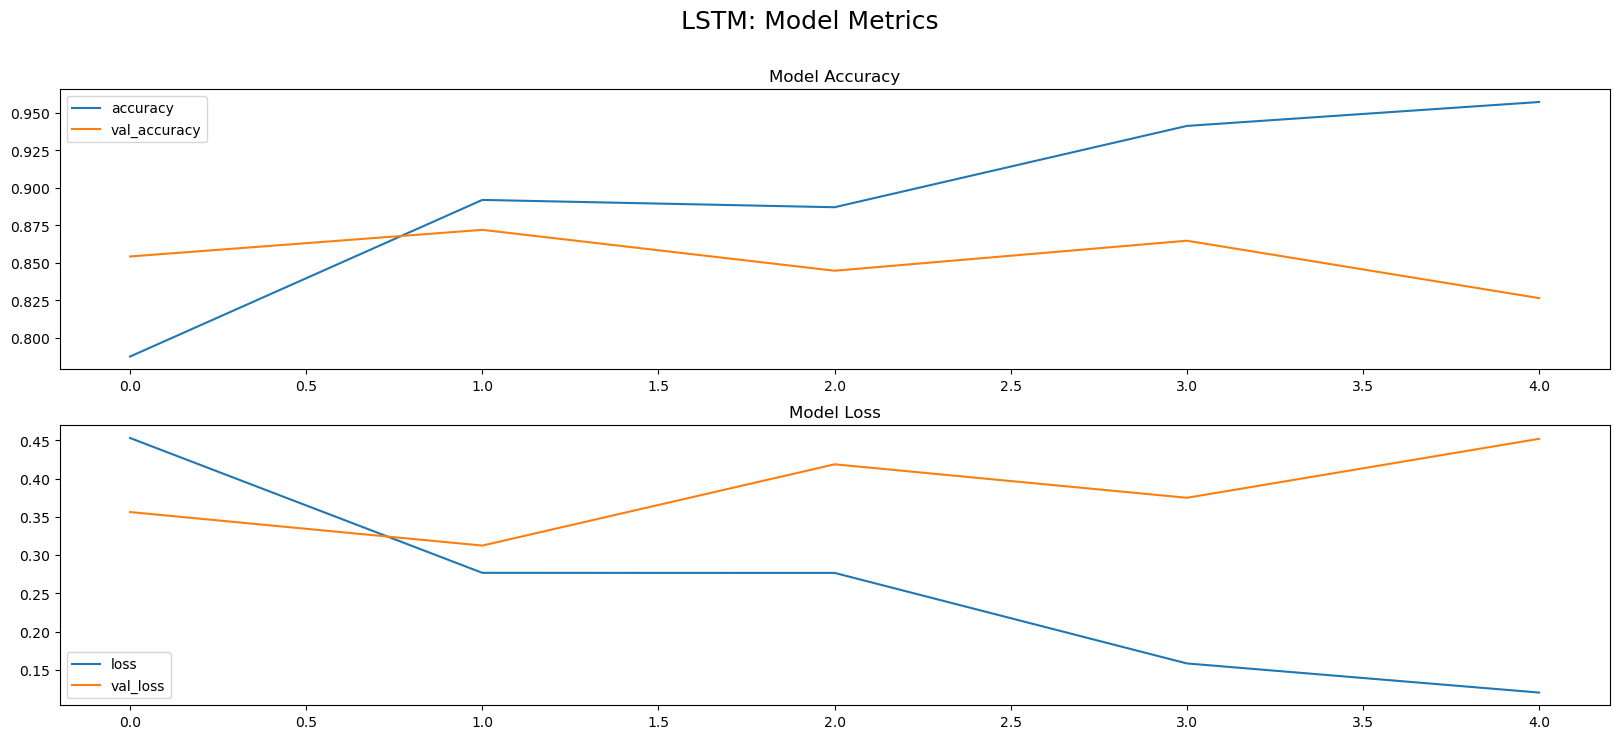

In [21]:
# Model Summary
model.summary()

# Early Stopping Callback
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Fit the Model
epochs = 10
batch_size = 16
history = model.fit(X_train_pd, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping])

plot_model_learning(history, 'LSTM')

In [22]:
X_test_data = test_data['text']
X_test_seq = tokenizer.texts_to_sequences(X_test_data)
X_test_pd = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Make Predictions
predictions = model.predict(X_test_pd)

# Convert the model's predictions back to sentiment labels
predicted_sentiments = [le.classes_[np.argmax(prediction)] for prediction in predictions]

# Add the predicted sentiments to the test DataFrame
test_data['predicted_sentiment'] = predicted_sentiments

# Display or save the results
print(test_data[['text', 'predicted_sentiment']])

test_data[['text', 'predicted_sentiment']].to_csv('/Users/millenasiqueiraguimaraes/Downloads/archive-2/predicted_sentiments.csv', index=False)

782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step
                                                    text predicted_sentiment
0      My daughter liked it but I was aghast, that a ...                 neg
1      I... No words. No words can describe this. I w...                 neg
2      this film is basically a poor take on the old ...                 neg
3      This is a terrible movie, and I'm not even sur...                 neg
4      First of all this movie is a piece of reality ...                 pos
...                                                  ...                 ...
24995  For one thing, he produced this movie. It has ...                 pos
24996  The title comes from an alteration an adolesce...                 pos
24997  Christopher Nolan's first film is a 'no budget...                 pos
24998  The story is shortly about the faith-lacking b...                 neg
24999  I found parts of this movie rather slow, espec...                 neg

[25000 rows x 2 columns]


## Evaluating the model

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have made predictions and added them to the 'test_df' DataFrame as 'predicted_sentiment'

# True labels from the test DataFrame
true_labels = test_data['sentiment']

# Predicted labels
predicted_labels = test_data['predicted_sentiment']

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')


Accuracy: 0.8630
Precision: 0.8632
Recall: 0.8630
F1-score: 0.8629


## Testing the model with a positive review

In [24]:
positive_review = "This movie was absolutely fantastic! The storyline was gripping and the acting was top-notch."

cleaned_review = clean_text(positive_review)

# Tokenize and pad the review
review_seq = tokenizer.texts_to_sequences([cleaned_review])
review_pad = pad_sequences(review_seq, maxlen=max_sequence_length)

# Predict the sentiment
prediction = model.predict(review_pad)
predicted_sentiment = le.classes_[np.argmax(prediction)]

print(f'Review: {positive_review}')
print(f'Predicted Sentiment: {predicted_sentiment}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Review: This movie was absolutely fantastic! The storyline was gripping and the acting was top-notch.
Predicted Sentiment: neg


## Testing the model with a negative review

In [25]:
negative_review = "This movie was absolutely terrible. The plot was boring and the acting was subpar."

cleaned_negative_review = clean_text(negative_review)

# Tokenize and pad the review
negative_review_seq = tokenizer.texts_to_sequences([cleaned_negative_review])
negative_review_pad = pad_sequences(negative_review_seq, maxlen=max_sequence_length)

# Predict the sentiment
negative_prediction = model.predict(negative_review_pad)
predicted_negative_sentiment = le.classes_[np.argmax(negative_prediction)]

print(f'Review: {negative_review}')
print(f'Predicted Sentiment: {predicted_negative_sentiment}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Review: This movie was absolutely terrible. The plot was boring and the acting was subpar.
Predicted Sentiment: neg


## Deployment - Incomplete


In [1]:
# Save model and tokenizer
model.save('h5')
with open('', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)


NameError: name 'model' is not defined